# Solution

To solve the proposed in the hackathon problem I decided to generate new metaparameters based on the Fourier spectrum of the `E`, `N` and `Z` seismic wave components. Then combine them with the initial metadata and classify  types of waves using Random Forest classifier.

# 1. Import required Python packages

In [19]:
import os
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

from scipy.signal import welch
from scipy import signal

# 2. Import training/testing dataset

In [23]:
df_train = pd.read_pickle('./data/df_train.pkl.gzip', compression='gzip')
df_test = pd.read_pickle('./data/df_test.pkl.gzip', compression='gzip')

In [24]:
df_train.head()

,label,target,trace_id,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_travel_sec,s_arrival_sample,source_origin_time,source_latitude,source_longitude,source_depth_km,snr_db_E,snr_db_N,snr_db_Z,E,N,Z
1,Near_Small,1,trace_1,33.598182,-116.596005,1374.8,500.0,7.39588,1833.0,2017-10-12 02:55:02.969,35.561667,-116.5697,13.92,39.799999,41.599998,39.500000,"[0.0, 3.884492e-05, 0.00037855064, 0.002025907...","[-0.0, -0.00013965365, 0.00040082424, -0.00251...","[0.0, 0.00020642515, -0.00026392427, 0.0005670..."
2,Far_Medium,5,trace_2,33.655160,-115.990060,538.0,800.0,8.64000,2055.2,2012-05-29 21:39:41.030,69.509000,-116.3350,5.56,22.900000,28.299999,22.299999,"[-0.0, 0.007055464, 0.02053014, -0.08816139, -...","[0.0, 0.0045861118, -0.013594023, -0.06492513,...","[0.0, 0.010553602, 0.04499443, 0.07075505, -0...."
4,Near_Medium,2,trace_4,19.333395,-155.385650,836.0,900.0,7.77000,1401.0,2018-04-23 03:03:17.385,33.075200,73.6821,9.41,12.600000,22.000000,18.299999,"[0.0, 0.00087343936, 0.001654511, 0.003251037,...","[-0.0, -0.0024113357, -0.0057321144, -0.017913...","[-0.0, -0.00079455395, -0.0040257163, -0.01145..."
5,Far_Small,4,trace_5,35.935700,-117.601700,1042.6,800.0,2.68000,1416.0,2013-03-11 16:56:06.060,38.612300,-122.6970,118.79,30.600000,29.100000,33.000000,"[-0.0, -0.00044424256, -0.00061723316, -0.0027...","[0.0, 2.6028414e-05, -0.00040918458, 0.0047532...","[0.0, 0.00034063237, 0.0003412804, 0.000484175..."
6,Noise,0,trace_6,64.564600,-165.373200,338.0,697.2,1.41000,674.0,2018-01-05 13:16:17.060,60.036800,-155.2055,2.17,47.099998,18.100000,49.400002,"[-0.0, -0.0059266915, -0.01604839, -0.04224359...","[-0.0, -0.0059266915, -0.01604839, -0.04224359...","[-0.0, -0.0059266915, -0.01604839, -0.04224359..."


# 3. Create PSD for the seismic wave components

In [26]:
sample_E = df_train['E'].iloc[0]
sample_N = df_train['N'].iloc[0]
sample_Z = df_train['Z'].iloc[0]

Text(0.5, 1.0, 'Z component')

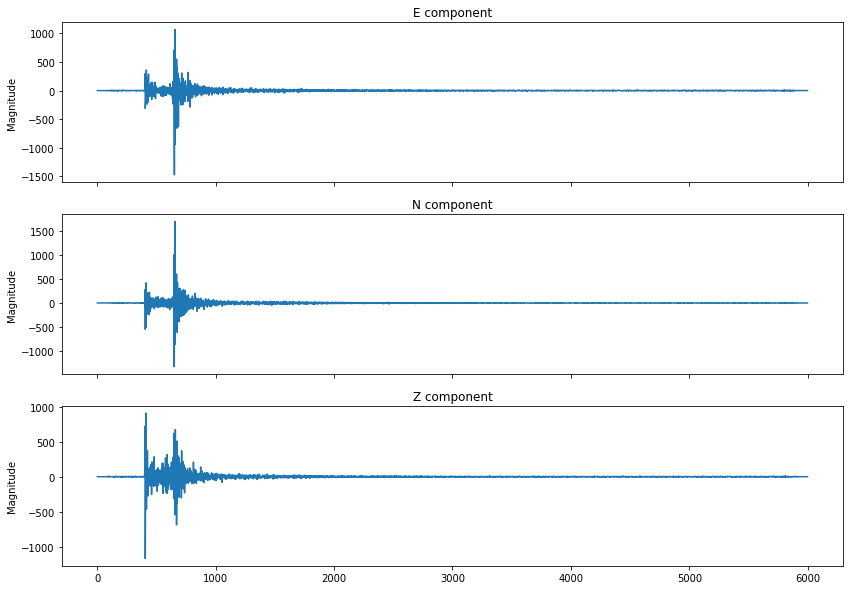

In [31]:
fig, ax = plt.subplots(3, 1, figsize = (14,10), sharex=True)

ax[0].plot(sample_E)
ax[0].set_ylabel('Magnitude')
ax[0].set_title('E component')

ax[1].plot(sample_N)
ax[1].set_ylabel('Magnitude')
ax[1].set_title('N component')

ax[2].plot(sample_Z)
ax[2].set_ylabel('Magnitude')
ax[2].set_title('Z component')

In [32]:
fs = 100
sample_E = np.pad(sample_E, (int(fs), int(fs)), 'constant')
freqs, psd_E = signal.welch(sample_E, fs, nperseg=1024)
psd_E = np.abs(psd_E)

sample_N = np.pad(sample_N, (int(fs), int(fs)), 'constant')
freqs, psd_N = signal.welch(sample_N, fs, nperseg=1024)
psd_N = np.abs(psd_N)

sample_Z = np.pad(sample_Z, (int(fs), int(fs)), 'constant')
freqs, psd_Z = signal.welch(sample_Z, fs, nperseg=1024)
psd_Z = np.abs(psd_Z)

Text(0.5, 0, 'Frequency')

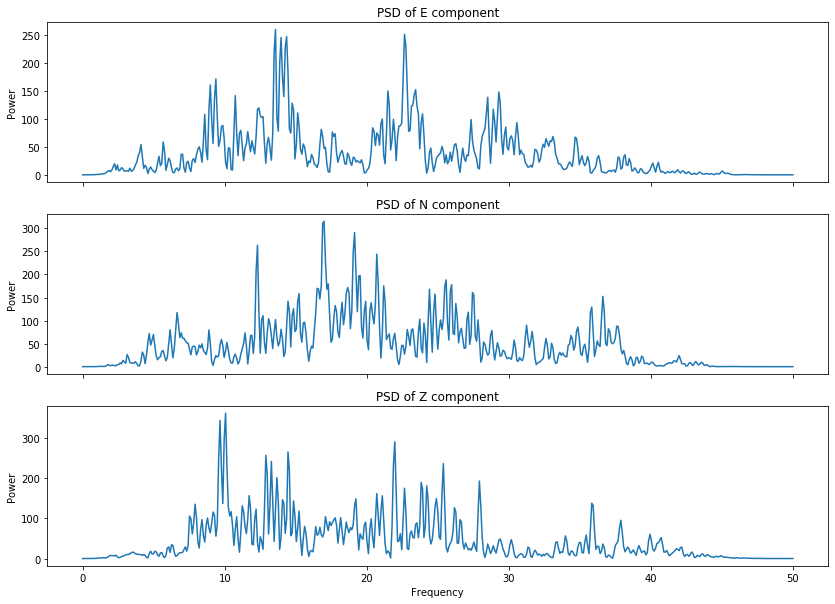

In [35]:
fig, ax = plt.subplots(3, 1, figsize = (14,10), sharex=True)

ax[0].plot(freqs, psd_E)
ax[0].set_ylabel('Power')
ax[0].set_title('PSD of E component')

ax[1].plot(freqs, psd_N)
ax[1].set_ylabel('Power')
ax[1].set_title('PSD of N component')

ax[2].plot(freqs, psd_Z)
ax[2].set_ylabel('Power')
ax[2].set_title('PSD of Z component')
ax[2].set_xlabel('Frequency')

Based on the PSD and the seismic wave in time domain I created 5 new metaparameters:

- snrMax - maximum SNR of the signal
- freqMax - frequency corresponding to the highest component of the PSD
- freqMean - frequency corresponding to the mean of few highest components of the PSD
- duration - duration of the strongest part of the signal
- tNew - time of the signal peak

In [36]:
def get_meta(sample, t0=0.0, fs=100):
    
    # Compute PSD of the signal
    sig = np.pad(sample, (int(fs), int(fs)), 'constant')
    freqs, psd = signal.welch(sig, fs, nperseg=1024)
    psd = np.abs(psd)
    
    # Compute the time shift of the peak
    tMax = np.argmax(np.abs(sample)) / fs
    tNew = tMax + t0
    
    # Compute the signal duration
    inds = sample.argsort()[-10:][::-1]
    duration = np.abs(np.max(inds) - np.min(inds)) / fs
    
    # Compute the signal mean and maximum frequency
    sel_freqs = freqs[psd.argsort()[-3:][::-1]]
    freqMean = np.mean(sel_freqs)
    freqMax = np.max(sel_freqs)
    
    # Compute the signal SNR
    psd_ave = np.sum(psd) / psd.shape[0]
    snrMax = np.sqrt(np.max(np.abs(sample)) / np.sqrt(psd_ave))

    meta = [
        tNew, duration, freqMean, freqMax, snrMax
    ]
    return meta, psd, freqs

In [37]:
meta_train_E = np.zeros((df_train.shape[0], 5))
psd_train_E = np.zeros((df_train.shape[0], 513))
i = 0
for row, item in df_train.iterrows():
    sample_E = item['E']
    meta, psd, _ = get_meta(sample_E)
    meta_train_E[i] = meta
    psd_train_E[i] = psd
    i += 1

In [38]:
meta_train_N = np.zeros((df_train.shape[0], 5))
psd_train_N = np.zeros((df_train.shape[0], 513))
i = 0
for row, item in df_train.iterrows():
    sample_N = item['N']
    meta, psd, _ = get_meta(sample_N)
    meta_train_N[i] = meta
    psd_train_N[i] = psd
    i += 1

In [39]:
meta_train_Z = np.zeros((df_train.shape[0], 5))
psd_train_Z = np.zeros((df_train.shape[0], 513))
i = 0
for row, item in df_train.iterrows():
    sample_Z = item['Z']
    meta, psd, _ = get_meta(sample_Z)
    meta_train_Z[i] = meta
    psd_train_Z[i] = psd
    i += 1

In [40]:
meta_train_ENZ = np.zeros((df_train.shape[0], 5))
psd_train_ENZ = np.zeros((df_train.shape[0], 513))
i = 0
for row, item in df_train.iterrows():
    sample_E = item['E']
    sample_N = item['N']
    sample_Z = item['Z']
    sample = sample_E + sample_N + sample_Z
    meta, psd, _ = get_meta(sample)
    meta_train_ENZ[i] = meta
    psd_train_ENZ[i] = psd
    i += 1

In [41]:
meta_test_E = np.zeros((df_test.shape[0], 5))
psd_test_E = np.zeros((df_test.shape[0], 513))
i = 0
for row, item in df_test.iterrows():
    sample_E = item['E']
    meta, psd, _ = get_meta(sample_E)
    meta_test_E[i] = meta
    psd_test_E[i] = psd
    i += 1

In [42]:
meta_test_N = np.zeros((df_test.shape[0], 5))
psd_test_N = np.zeros((df_test.shape[0], 513))
i = 0
for row, item in df_test.iterrows():
    sample_N = item['N']
    meta, psd, _ = get_meta(sample_N)
    meta_test_N[i] = meta
    psd_test_N[i] = psd
    i += 1

In [43]:
meta_test_Z = np.zeros((df_test.shape[0], 5))
psd_test_Z = np.zeros((df_test.shape[0], 513))
i = 0
for row, item in df_test.iterrows():
    sample_Z = item['Z']
    meta, psd, _ = get_meta(sample_Z)
    meta_test_Z[i] = meta
    psd_test_Z[i] = psd
    i += 1

# 4. Preprocess data for the training 

Prepare the labels and scale the input data

In [44]:
# List names of classes
np.unique(df_train['label'])

array(['Far_Large', 'Far_Medium', 'Far_Small', 'Near_Large',
       'Near_Medium', 'Near_Small', 'Noise'], dtype=object)

In [45]:
classes = ['Noise', 'Far_Large', 'Far_Medium', 'Far_Small', 'Near_Large',
       'Near_Medium', 'Near_Small']

In [46]:
# List available metadata
df_train.columns

Index(['label', 'target', 'trace_id', 'receiver_latitude',
       'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
       'p_travel_sec', 's_arrival_sample', 'source_origin_time',
       'source_latitude', 'source_longitude', 'source_depth_km', 'snr_db_E',
       'snr_db_N', 'snr_db_Z', 'E', 'N', 'Z'],
      dtype='object')

In [47]:
# Choose the initial metaparameters you want to use for the training
columns = ['receiver_latitude', 'receiver_longitude',
       'receiver_elevation_m', 'p_arrival_sample', 'p_travel_sec',
       's_arrival_sample', 'source_latitude', 'source_longitude',
       'source_depth_km', 'snr_db_E', 'snr_db_N', 'snr_db_Z']

In [48]:
# Drop the rest of parameters not used in further analysis
df_train = df_train.drop(['label','trace_id','E','N','Z','source_origin_time'],axis=1).dropna()
df_test = df_test.drop(['label','trace_id','E','N','Z','source_origin_time'],axis=1).dropna()

In [49]:
# Extract the labels
y_train = df_train['target'].values
y_test = df_test['target'].values

In [50]:
# Merge initial metaparameters with newly generated to create the input matrix
X_train = np.hstack((df_train[columns].values, meta_train_E, meta_train_N, meta_train_Z))
X_test = np.hstack((df_test[columns].values, meta_test_E, meta_test_N, meta_test_Z))

In [51]:
# Scale the data to the range 0-1
max_scalers = np.max(X_train, axis=0)
min_scalers = np.min(X_train, axis=0)

In [52]:
X_train = (X_train - min_scalers) / (max_scalers - min_scalers)

In [53]:
X_test = (X_test - min_scalers) / (max_scalers - min_scalers)

# 5. Train the classifier

Tweaking the hyperparameters of the model might help in increase of the final classification accuracy.

In [54]:
rf = RandomForestClassifier(max_depth=25, n_estimators=200, max_features=5, verbose=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   10.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


# 6. Test the model

In [55]:
# Compute the error rate
error_rate(y_test, y_pred)

0.22807017543859648

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       439
           1       0.80      0.75      0.78       439
           2       0.70      0.76      0.73       440
           3       0.83      0.81      0.82       440
           4       0.73      0.74      0.74       440
           5       0.60      0.60      0.60       440
           6       0.77      0.75      0.76       440

    accuracy                           0.77      3078
   macro avg       0.77      0.77      0.77      3078
weighted avg       0.77      0.77      0.77      3078



Create the confusion matrix

In [57]:
cms = confusion_matrix(y_test, y_pred)

In [58]:
test_score = np.trace(cms) / np.sum(cms)

In [59]:
new_cms = np.zeros((7,7))
for x in range(7):
    for y in range(7):
        new_cms[x,y] = cms[x,y] / np.sum(cms[x])

Text(0, 0.5, 'Predicted data')

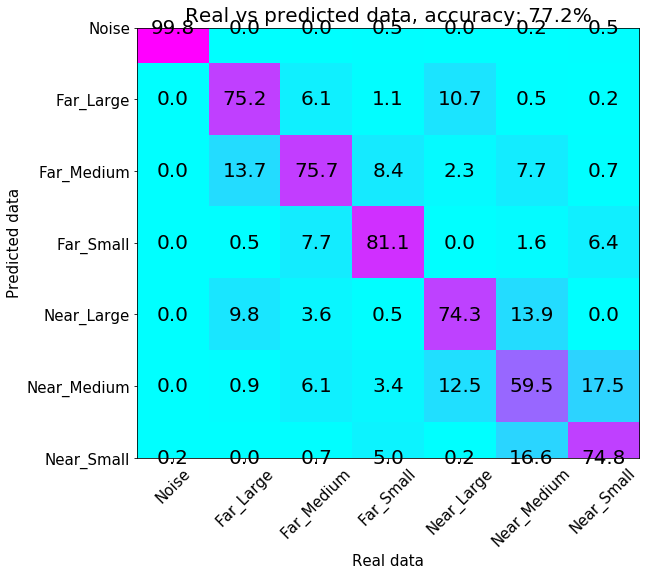

In [66]:
fig = plt.figure(figsize=(9, 9))
n_classes = 7
ax = fig.add_subplot(111)
im = ax.imshow(np.transpose(new_cms), interpolation="nearest", cmap="cool")
rows = cms.shape[0]
cols = cms.shape[1]


for x in range(0, rows):
    for y in range(0, cols):
        #value = int(cms[x, y])
        value = round(cms[x,y] / np.sum(cms[x])*100,1)
        ax.text(x, y, value, color="black", ha="center", va="center", fontsize=20)
plt.title("Real vs predicted data, accuracy: " + str(np.around(test_score*100, 1)) + "%", fontsize=20)

classes_values = []
classes_labels = classes

for n in range(n_classes):
    classes_values.append(n)

plt.xticks(classes_values, classes_labels, rotation=45, fontsize=15)
plt.yticks(classes_values, classes_labels, fontsize=15)
plt.xlabel("Real data", fontsize=15)
plt.ylabel("Predicted data", fontsize=15)

# 7. Generate the file for submission

In [ ]:
df_submission = pd.read_pickle('./data/df_submission.pkl.gzip', compression='gzip')

In [ ]:
trace_id = df_submission['trace_id'].values

In [ ]:
meta_sub_E = np.zeros((df_submission.shape[0], 5))
psd_sub_E = np.zeros((df_submission.shape[0], 513))
i = 0
for row, item in df_submission.iterrows():
    sample_E = item['E']
    meta, psd, _ = get_meta(sample_E)
    meta_sub_E[i] = meta
    psd_sub_E[i] = psd
    i += 1

In [ ]:
meta_sub_N = np.zeros((df_submission.shape[0], 5))
psd_sub_N = np.zeros((df_submission.shape[0], 513))
i = 0
for row, item in df_submission.iterrows():
    sample_N = item['N']
    meta, psd, _ = get_meta(sample_N)
    meta_sub_N[i] = meta
    psd_sub_N[i] = psd
    i += 1

In [ ]:
meta_sub_Z = np.zeros((df_submission.shape[0], 5))
psd_sub_Z = np.zeros((df_submission.shape[0], 513))
i = 0
for row, item in df_submission.iterrows():
    sample_Z = item['Z']
    meta, psd, _ = get_meta(sample_Z)
    meta_sub_Z[i] = meta
    psd_sub_Z[i] = psd
    i += 1

In [ ]:
df_submission = df_submission.drop(['trace_id','E','N','Z','source_origin_time'],axis=1).dropna()

In [ ]:
X_test_sub = np.hstack((df_submission[columns].values, meta_sub_E, meta_sub_N, meta_sub_Z))

In [ ]:
X_test_sub = (X_test_sub - min_scalers) / (max_scalers - min_scalers)

In [ ]:
y_pred_sb = rf.predict(X_test_sub)

In [ ]:
df_submit = pd.DataFrame({'trace_id' : trace_id,
                          'submission' : y_pred_sb})

In [ ]:
df_submit.head()

In [ ]:
df_submit.to_csv('./fm_meta_submission.csv',index=False)